In [1]:
import sys
from pathlib import Path

# Add parent directory to Python path
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

import torch
import scanpy as sc
import anndata as ad
import celldiffusion as cd


/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


In [5]:
# Use paths relative to the project root (parent directory of this notebook)
DATA_PATH = str(parent_dir / 'data' / 'input') + '/'

OUTPUT_PATH = str(parent_dir / 'data' / 'output') + '/'


# Load dataset

In [6]:
adata = sc.read_h5ad(DATA_PATH + 'pbmc10k_rm100pct.h5ad')

adata

AnnData object with n_obs × n_vars = 8626 × 3346
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

# Preprocess

/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  return fn(*args_all, **kw)


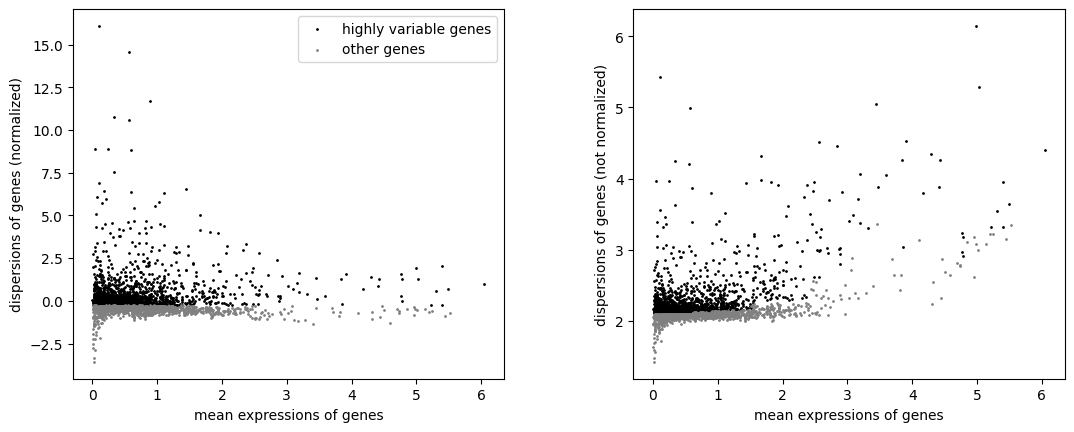

In [7]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [8]:
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 8626 × 2000
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

# Feature encoder

In [17]:
cd.encode_features(adata, 
                   D_encode_list=[2000, 50, 8], # Encoder dimension in each layer
                   D_decode_list=[8, 500, 2000], # Decoder dimension in each layer
                   max_epoch=2000, # number of epoch
                   lr=1e-3,        # learning rate
                   device=device)


2025-12-19 11:55:19,565 - --------> Starting feature encoder ...
/Users/liuyuchen/Proj/Private_CellDiffusion/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2025-12-19 11:55:19,657 - ------------------------> Epoch: 1/2000, Current loss: 13346551.0000
2025-12-19 11:55:21,668 - ------------------------> Epoch: 51/2000, Current loss: 6312736.5000
2025-12-19 11:55:23,654 - ------------------------> Epoch: 101/2000, Current loss: 6152743.5000
2025-12-19 11:55:25,631 - ------------------------> Epoch: 151/2000, Current loss: 6093288.5000
2025-12-19 11:55:27,596 - ------------------------> Epoch: 201/2000, Current loss: 6056023.0000
2025-12-19 11:55:29,597 - ------------------------> Epoch: 251/2000, Current loss: 6028355.50

# Integration

In [18]:
# Build the diffusion graph for data intagration

cd.inte.build_integration_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

In [19]:
# Build the input KNN adjacencies for each batch, which is used in loss function.

cd.inte.build_integration_loss_adj(adata, 
                                   use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                                   k=50,            # K for building KNN graph
                                   device=device)

In [21]:
cd.inte.integration_diffusion(adata, 
                              use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                              max_epoch=2000,  # The number of training epoch
                              lr=1e-3,         # Learning rate
                              num_features_diffusion=8,
                              num_heads_diffusion=2,
                              num_steps_diffusion=2,
                              time_increment_diffusion=0.5, # Suggested value==0.2 when using 8 diffusion layers.
                              device=device)


2025-12-19 11:57:48,087 - --------> Starting data integration ...
2025-12-19 11:57:48,281 - ------------------------> Epoch: 1/2000, Current loss: 1069890048.0000
2025-12-19 11:57:55,504 - ------------------------> Epoch: 51/2000, Current loss: 28565896.0000
2025-12-19 11:58:02,709 - ------------------------> Epoch: 101/2000, Current loss: 26235840.0000
2025-12-19 11:58:10,061 - ------------------------> Epoch: 151/2000, Current loss: 26063756.0000
2025-12-19 11:58:17,335 - ------------------------> Epoch: 201/2000, Current loss: 25999240.0000
2025-12-19 11:58:24,655 - ------------------------> Epoch: 251/2000, Current loss: 25965580.0000
2025-12-19 11:58:31,859 - ------------------------> Epoch: 301/2000, Current loss: 25945080.0000
2025-12-19 11:58:38,691 - ------------------------> Epoch: 351/2000, Current loss: 25931384.0000
2025-12-19 11:58:45,688 - ------------------------> Epoch: 401/2000, Current loss: 25921656.0000
2025-12-19 11:58:52,595 - ------------------------> Epoch: 451

## View integrated embeddings

In [23]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=8)
sc.tl.umap(adata)

/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


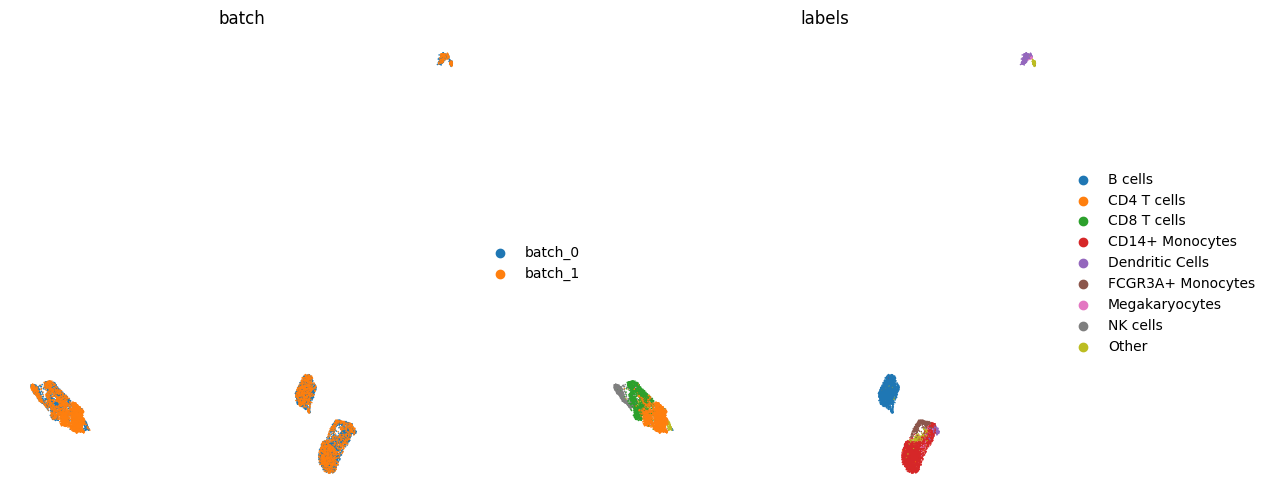

In [24]:
from matplotlib import rcParams
FIGSIZE = (6, 6)
rcParams["figure.figsize"] = FIGSIZE

sc.pl.umap(adata, color=['batch', 'labels'], frameon=False, size=5, ncols=2)

# Save integrated data

In [25]:
adata.write(OUTPUT_PATH + 'scDiffusion_integration.h5ad')

In [14]:
adata = ad.read_h5ad(OUTPUT_PATH + 'scDiffusion_integration.h5ad')
